<a href="https://colab.research.google.com/github/adityaslg2001/Python-JupyterNotebook/blob/main/anomaly-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# --------------------------
# Import Libraries
# --------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

%matplotlib inline

np.random.seed(42)


In [28]:
# --------------------------
# Load Data and Initial Exploration (God Level EDA)
# --------------------------
# Load the training data

train_df = pd.read_parquet('/content/train.parquet')


print("----- First 5 Rows -----")
display(train_df.head())


print("----- Data Info -----")
train_df.info()

print("----- Summary Statistics -----")
display(train_df.describe())

# Check for missing values so that there isnt any outliers present before training
print("----- Missing Values -----")
print(train_df.isnull().sum())

----- First 5 Rows -----


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


----- Data Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 87.6+ MB
----- Summary Statistics -----


,Date,X1,X2,X3,X4,X5
count,1639424,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06
mean,2022-12-03 07:23:43.817145600,1.139258e+00,5.488189e+00,4.110388e+32,2.706323e+29,1.187219e+00
min,2020-12-16 00:00:00,1.000000e+00,5.412539e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,2021-12-10 00:00:00,1.049171e+00,5.480597e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,2022-11-30 00:00:00,1.105171e+00,5.488979e+00,1.000000e+00,1.000000e+00,6.931472e-01
75%,2023-11-23 00:00:00,1.214096e+00,5.496717e+00,1.000000e+00,2.718282e+00,2.890372e+00
max,2024-12-11 00:00:00,4.014850e+00,5.541852e+00,1.651636e+38,5.540622e+34,3.465736e+00
std,NaN,1.391992e-01,1.342811e-02,2.346156e+35,5.812988e+31,1.304814e+00


----- Missing Values -----
Date      0
X1        0
X2        0
X3        0
X4        0
X5        0
target    0
dtype: int64



'Anomaly' column not found. Creating synthetic target column based on X4 values.


<ipython-input-30-afd7a751ed55>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='anomaly', data=train_df, palette='viridis')


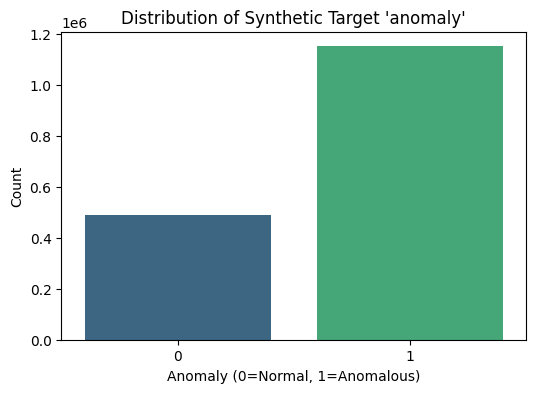

In [30]:
# --------------------------
# Creating a target column & additional Feature Engineering
# --------------------------

# we will create a col, we can see that X4 takes on two distinct values.
# Here we assume that rows where X4 is exactly 1.0 indicate anomalous behavior.

if 'anomaly' not in train_df.columns:
    print("\n'Anomaly' column not found. Creating synthetic target column based on X4 values.")
    train_df['anomaly'] = (train_df['X4'] == 1.0).astype(int)

# verifying the synthetic target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='anomaly', data=train_df, palette='viridis')
plt.title("Distribution of Synthetic Target 'anomaly'")
plt.xlabel("Anomaly (0=Normal, 1=Anomalous)")
plt.ylabel("Count")
plt.show()


<ipython-input-31-d60ca73f9f59>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='anomaly', data=train_df, palette='viridis')


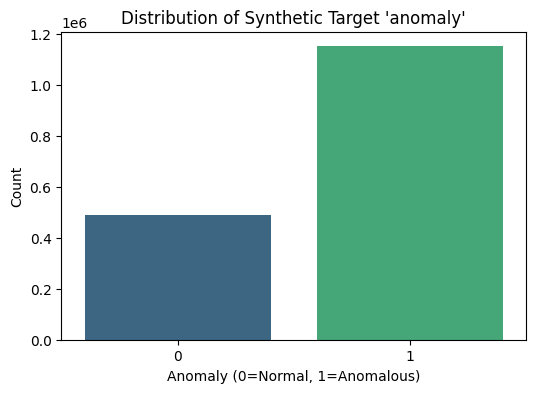

In [31]:
# Verify the synthetic target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='anomaly', data=train_df, palette='viridis')
plt.title("Distribution of Synthetic Target 'anomaly'")
plt.xlabel("Anomaly (0=Normal, 1=Anomalous)")
plt.ylabel("Count")
plt.show()

In [32]:
# Additional feature engineering:

train_df['Date'] = pd.to_datetime(train_df['Date'])

# Extract features from Date (even if not directly predictive, they can sometimes help so
# it makes sense i guess to remove as much categorical data from the training data)

train_df['day'] = train_df['Date'].dt.day
train_df['month'] = train_df['Date'].dt.month
train_df['year'] = train_df['Date'].dt.year

train_df['X1_to_X2'] = train_df['X1'] / (train_df['X2'] + 1e-6)
train_df['X3_diff_X5'] = train_df['X3'] - train_df['X5']

# Drop the raw categorical Date column
train_df.drop(columns=['Date'], inplace=True)

print("------------ Data after feature engineering -----")
display(train_df.head())

------------ Data after feature engineering -----


,X1,X2,X3,X4,X5,target,anomaly,day,month,year,X1_to_X2,X3_diff_X5
0,1.518921,5.463154,1.0,2.718282,2.890372,0,0,16,12,2020,0.278030,-1.890372
1,1.546509,5.458010,1.0,2.718282,2.833213,1,0,16,12,2020,0.283347,-1.833213
2,1.645427,5.456560,1.0,7.389056,2.890372,1,0,16,12,2020,0.301550,-1.890372
3,1.652022,5.458479,1.0,2.718282,2.890372,1,0,16,12,2020,0.302652,-1.890372
4,1.695538,5.466709,1.0,2.718282,2.890372,0,0,16,12,2020,0.310157,-1.890372


ValueError: Maximum allowed size exceeded

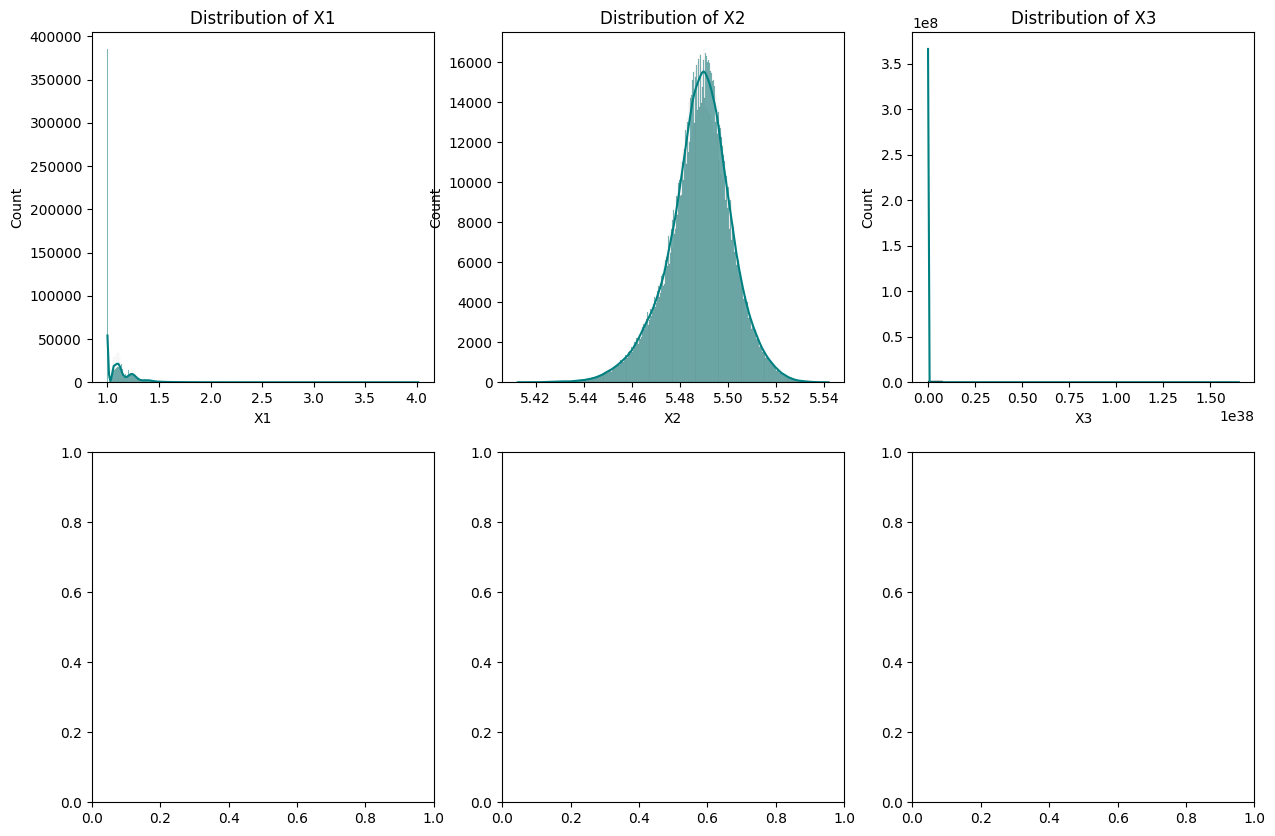

In [33]:
# --------------------------
# Further EDA on Engineered Features
# --------------------------
# sensor distributions

sensor_cols = ['X1', 'X2', 'X3', 'X4', 'X5']
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.ravel()
for i, col in enumerate(sensor_cols):
    sns.histplot(train_df[col], kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


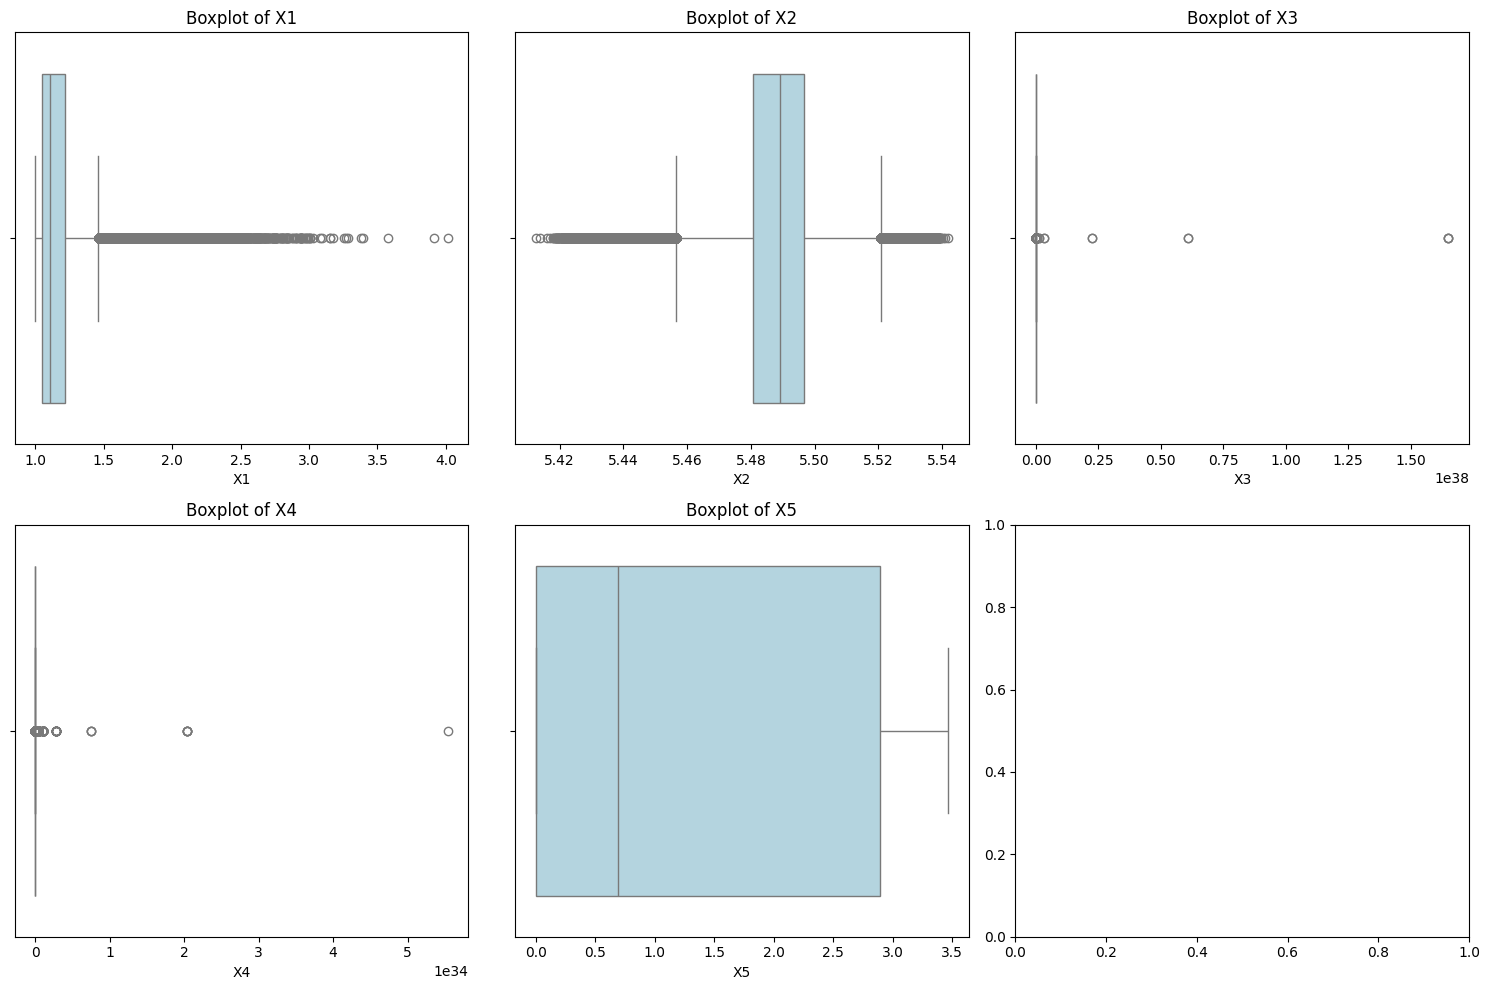

In [34]:
# boxplots to inspect outliers
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.ravel()
for i, col in enumerate(sensor_cols):
    sns.boxplot(x=train_df[col], ax=axes[i], color='lightblue')
    axes[i].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

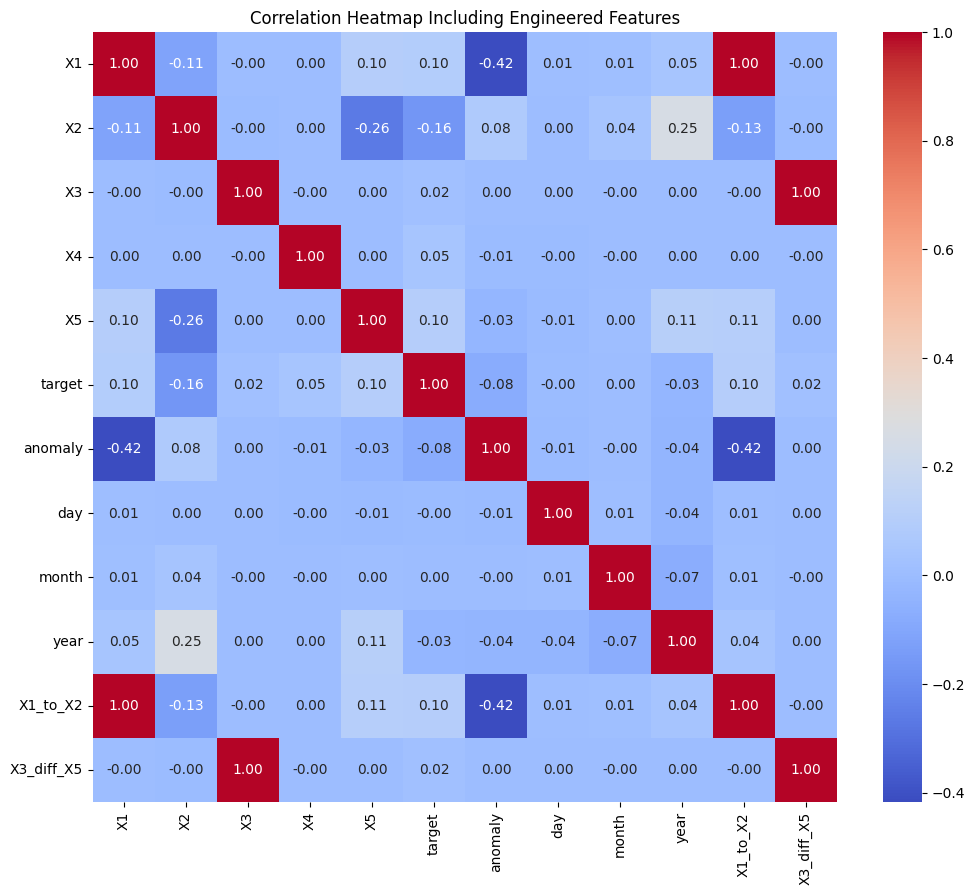

In [35]:
# corelation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap Including Engineered Features")
plt.show()

In [37]:
# Prepare Data for Modeling
# -------------------------
features = sensor_cols + ['day', 'month', 'year', 'X1_to_X2', 'X3_diff_X5']
target = 'anomaly'

X = train_df[features]
y = train_df[target]

# data will split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [36]:
# --------------------------
# Build a pipeline with columnTransformer
# --------------------------
# Since all our features are numeric after we dropped the date column, we set up a transformer for numeric data.
numeric_features = features

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# creating the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# pipeline that preprocesses the data and then fits a model.
# we can use a RandomForestClassifier.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [38]:
# --------------------------
# Train the Model
# --------------------------
model_pipeline.fit(X_train, y_train)

# --------------------------
# Evaluate the Model
# --------------------------
y_pred = model_pipeline.predict(X_val)

print("----- -------Model Evaluation on Validation Set -----")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


----- -------Model Evaluation on Validation Set -----
Accuracy: 0.8664836756789728
F1 Score: 0.9067195663476207

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77     97937
           1       0.89      0.93      0.91    229948

    accuracy                           0.87    327885
   macro avg       0.85      0.83      0.84    327885
weighted avg       0.86      0.87      0.86    327885



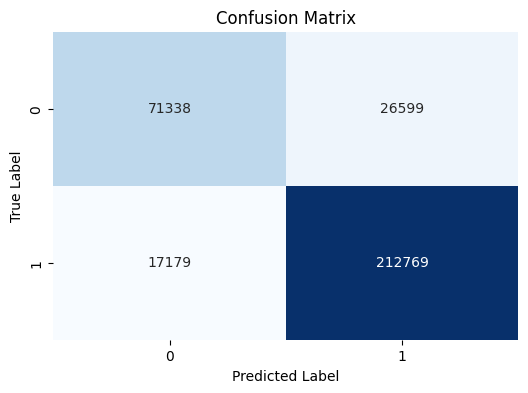

In [39]:
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [40]:
# --------------------------
# model & hyperparameter tuning with XGBoost
# --------------------------

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

In [21]:
grid_search = GridSearchCV(model_pipeline_xgb, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

y_pred_xgb = grid_search.predict(X_val)
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("XGBoost F1 Score:", f1_score(y_val, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_val, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 9, 'classifier__n_estimators': 200}
XGBoost Accuracy: 0.8110587553562987
XGBoost F1 Score: 0.8723562511460967

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.55      0.64     97937
           1       0.83      0.92      0.87    229948

    accuracy                           0.81    327885
   macro avg       0.79      0.74      0.75    327885
weighted avg       0.80      0.81      0.80    327885



In [23]:
# Using the RandomForest pipeline:
best_model = model_pipeline

In [42]:
test_df = pd.read_parquet('/content/test.parquet')

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['day'] = test_df['Date'].dt.day
test_df['month'] = test_df['Date'].dt.month
test_df['year'] = test_df['Date'].dt.year

test_df['X1_to_X2'] = test_df['X1'] / (test_df['X2'] + 1e-6)
test_df['X3_diff_X5'] = test_df['X3'] - test_df['X5']

test_df.drop(columns=['Date'], inplace=True)

features = ['X1', 'X2', 'X3', 'X4', 'X5', 'day', 'month', 'year', 'X1_to_X2', 'X3_diff_X5']
X_test = test_df[features]

# final prediction using best model. i used randomforest pipeline which yielded the best result.
final_predictions = best_model.predict(X_test)

In [43]:
# submission DataFrame.
submission = pd.DataFrame({
    'ID': test_df.index,
    'Prediction': final_predictions
})

In [44]:
# Saving the final predictions to a CSV file.
submission.to_csv('Final_Submission.csv', index=False)

print("Final submission CSV 'final_submission.csv' has been created.")

Final submission CSV 'final_submission.csv' has been created.
